# Topic Modeling via Large Language Models (LLM)

In [1]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
from datetime import date

from llm import append_llm_output, generate_llm_output
from helper import assign_categories, bert_scorer, rouge_scorer
from prompts import system_prompt_topic, topic_introduction, topic_instructions
from prompts import system_prompt_sentiment, sentiment_introduction, sentiment_instructions

import warnings
warnings.filterwarnings("ignore")

## Ingestion

In [2]:
# Create validation set
df = pd.read_csv('data/news_cleaned.csv')
valid_df = df[['matchdatetime', 'station', 'snippet']].sample(250).sort_index(ascending=True)
valid_df['gpt_topic_label'] = pd.NaT
valid_df['Rank'] = range(1, len(valid_df) + 1)
valid_df.head()

,matchdatetime,station,snippet,gpt_topic_label,Rank
594,2017-11-06 01:21:16,BBCNEWS,of vunidogoloa deal with the effects of climat...,NaT,1
1072,2017-05-31 23:07:38,BBCNEWS,california he will work with other countries t...,NaT,2
1889,2014-09-22 18:42:36,CNN,new york city. a live picture now of the finan...,NaT,3
2398,2009-09-21 11:59:50,MSNBC,"moment. and climate change. yeah, but first a ...",NaT,4
4003,2010-08-10 05:54:47,MSNBC,the white house's top energy adviser says ther...,NaT,5


In [3]:
# # Read validation set
# valid_df = pd.read_csv('data/topic_validations.csv', index_col=0)
# valid_df = valid_df.drop(columns=['snippet_no_climate'])
# valid_df.head()

## Topic Modeling

### Label Snippets

In [4]:
topic_payload = {
    "system_prompt": system_prompt_topic,
    "introduction": topic_introduction,
    "instruction": topic_instructions
}

In [5]:
# Update the DataFrame with topic labels
result_col = 'gpt_topic_label'
gpt_output_df = append_llm_output(df=valid_df, payload=topic_payload, result_col=result_col)

# Copy dataframe
label_df = gpt_output_df

# Display the updated DataFrame
gpt_output_df

,matchdatetime,station,snippet,gpt_topic_label,Rank
594,2017-11-06 01:21:16,BBCNEWS,of vunidogoloa deal with the effects of climat...,Unknown,1
1072,2017-05-31 23:07:38,BBCNEWS,california he will work with other countries t...,climate change advisor,2
1889,2014-09-22 18:42:36,CNN,new york city. a live picture now of the finan...,protesters challenge Wall Street,3
2398,2009-09-21 11:59:50,MSNBC,"moment. and climate change. yeah, but first a ...",Unknown,4
4003,2010-08-10 05:54:47,MSNBC,the white house's top energy adviser says ther...,climate legislation chance,5
...,...,...,...,...,...
88582,2018-09-16 16:06:19,CNN,"example, in hurricane harvey. this is also an ...",reduce greenhouse gas,246
89166,2016-12-28 12:34:50,CNN,is going to run the epa and this is a climate ...,climate change denier,247
89373,2019-07-01 01:44:54,BBCNEWS,climate change protesters descended on westmin...,greenhouse gas reduction,248
89627,2019-07-24 17:00:56,BBCNEWS,to the people and come out of the eu on octobe...,climate change protesters,249


### Analysis of Topic Labels

In [22]:
# Import Previously labeled set
label_df = pd.read_csv('data/lda_topic_labels_v3.csv')
label_df = label_df.drop(columns=['Unnamed: 0', 
                                  'Rank', 
                                #   'lda_topic_label13'
                                  ])
label_df.head()

,matchdatetime,station,snippet,gpt_topic_label,lda_topic_label23,lda_topic_label2
0,2017-11-06 01:21:16,BBCNEWS,of vunidogoloa deal with the effects of climat...,Unknown,Unknown,Unknown
1,2017-05-31 23:07:38,BBCNEWS,california he will work with other countries t...,climate change advisor,Unknown,Unknown
2,2014-09-22 18:42:36,CNN,new york city. a live picture now of the finan...,protesters challenge Wall Street,believe climate change,barrier reef
3,2009-09-21 11:59:50,MSNBC,"moment. and climate change. yeah, but first a ...",Unknown,Unknown,Unknown
4,2010-08-10 05:54:47,MSNBC,the white house's top energy adviser says ther...,climate legislation chance,Unknown,Unknown


In [23]:
# Value counts of labels
top_10_labels = label_df['gpt_topic_label'].value_counts().nlargest(10)
top_10_labels

gpt_topic_label
Unknown                      53
global warming impact         8
climate change impact         7
greenhouse gas reduction      7
climate change denial         4
climate change discussion     3
climate impact assessment     3
climate change debate         3
global warming concern        3
climate change activism       2
Name: count, dtype: int64

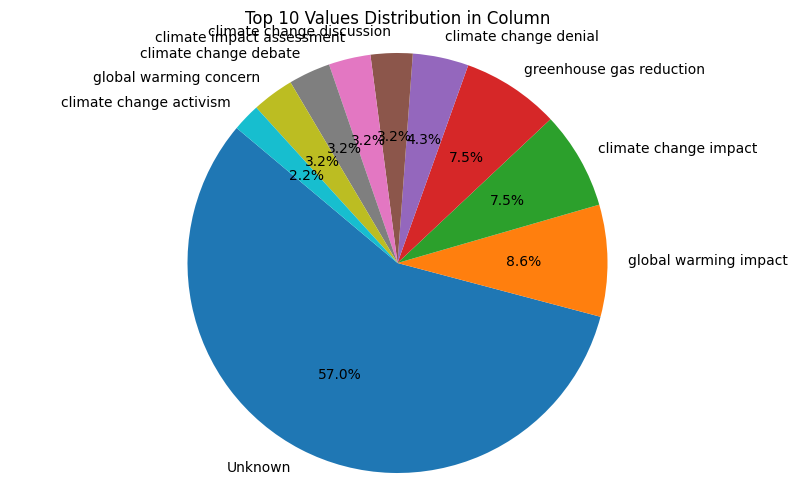

In [24]:
# Value counts of labels
top_10_labels = label_df['gpt_topic_label'].value_counts().nlargest(10)

# Creating the pie chart
plt.figure(figsize=(10, 6))
plt.pie(top_10_labels, labels=top_10_labels.index, autopct='%1.1f%%', startangle=140)
# plt.pie(top_10_labels, labels=None, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Values Distribution in Column')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

'Unknown's account for 21.2% of the total GPT output.

In [25]:
gpt_topic_list = label_df.loc[label_df['gpt_topic_label'] != 'Unknown', 'gpt_topic_label'].unique()
# gpt_topic_list

In [26]:
categories = assign_categories(gpt_topic_list, num_clusters=5)
pprint.pp(categories)

{'climate change impact': ['climate change advisor',
                           'climate change threat',
                           'climate change protest',
                           'fighting climate change',
                           'climate change misinformation',
                           'climate change concern',
                           'climate change research',
                           'climate change danger',
                           'climate change skeptic',
                           'climate change belief',
                           'climate change denial',
                           'climate change impact assessment',
                           'climate change pivot',
                           'climate change mitigation',
                           'climate change impact',
                           'climate change investigations',
                           'climate change chief',
                           'climate change awareness',
                        

In [27]:
# Display categories
categories.keys()

dict_keys(['climate change impact', 'climate crisis', 'carbon emissions reduction', 'climate action efforts', 'global warming impact'])

In [28]:
# Assign categories to their respective labels
for category_name, topic_labels in categories.items():
    # For each topic label in the list for the current category, update the 'category' column in the DataFrame
    label_df.loc[label_df['gpt_topic_label'].isin(topic_labels), 'category'] = category_name

label_df

,matchdatetime,station,snippet,gpt_topic_label,lda_topic_label23,lda_topic_label2,category
0,2017-11-06 01:21:16,BBCNEWS,of vunidogoloa deal with the effects of climat...,Unknown,Unknown,Unknown,NaN
1,2017-05-31 23:07:38,BBCNEWS,california he will work with other countries t...,climate change advisor,Unknown,Unknown,climate change impact
2,2014-09-22 18:42:36,CNN,new york city. a live picture now of the finan...,protesters challenge Wall Street,believe climate change,barrier reef,carbon emissions reduction
3,2009-09-21 11:59:50,MSNBC,"moment. and climate change. yeah, but first a ...",Unknown,Unknown,Unknown,NaN
4,2010-08-10 05:54:47,MSNBC,the white house's top energy adviser says ther...,climate legislation chance,Unknown,Unknown,climate crisis
...,...,...,...,...,...,...,...
245,2018-09-16 16:06:19,CNN,"example, in hurricane harvey. this is also an ...",reduce greenhouse gas,address climate change,action climate,carbon emissions reduction
246,2016-12-28 12:34:50,CNN,is going to run the epa and this is a climate ...,climate change denier,Unknown,Unknown,climate change impact
247,2019-07-01 01:44:54,BBCNEWS,climate change protesters descended on westmin...,greenhouse gas reduction,greenhouse gas,activists arrested blocking,carbon emissions reduction
248,2019-07-24 17:00:56,BBCNEWS,to the people and come out of the eu on octobe...,climate change protesters,Unknown,Unknown,climate change impact


### Output Evaluation

In [29]:
# Evaluation dataframe
eval_df = pd.DataFrame({
    'snippet': label_df['snippet'],
    'gpt_cat': label_df['category'].fillna('Unknown'),
    'lda_cat': label_df['lda_topic_label2'],
    'bert_score': pd.NaT
})
eval_df.head()

,snippet,gpt_cat,lda_cat,bert_score
0,of vunidogoloa deal with the effects of climat...,Unknown,Unknown,NaT
1,california he will work with other countries t...,climate change impact,Unknown,NaT
2,new york city. a live picture now of the finan...,carbon emissions reduction,barrier reef,NaT
3,"moment. and climate change. yeah, but first a ...",Unknown,Unknown,NaT
4,the white house's top energy adviser says ther...,climate crisis,Unknown,NaT


In [30]:
# Calculate bert score between topic labels
eval_df['bert_score'] = eval_df.apply(lambda row: bert_scorer(row['gpt_cat'], row['lda_cat']), axis=1)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

In [31]:
eval_df = eval_df.drop(eval_df[(eval_df['gpt_cat'] == 'Unknown') & (eval_df['lda_cat'] == 'Unknown')].index)
eval_df.sample(15)


,snippet,gpt_cat,lda_cat,bert_score
36,shifting positions on gay rights and global wa...,Unknown,address climate,0.862316
75,abortion and so forth. but he has put inequali...,carbon emissions reduction,Unknown,0.863448
89,jane: trying to pull the country out of the re...,climate change impact,Unknown,0.837607
44,"is now. the deniers behind one thing,' citizen...",climate change impact,Unknown,0.837607
40,"looming over the mueller probe. new today, the...",global warming impact,address climate,0.899216
212,order mlb extra innings for a great low price ...,climate crisis,Unknown,0.875893
166,the president will attend a climate change sum...,climate crisis,Unknown,0.875893
121,a camera might figure it out. that was easy! g...,climate crisis,Unknown,0.875893
6,to withdraw the united states from the paris c...,climate crisis,barrier reef,0.885097
142,people in the most vulnerable parts of the wor...,climate change impact,Unknown,0.837607


In [33]:
eval_df['bert_score'].max()

0.9033691883087158

In [36]:
eval_df.to_csv('data/topic_eval_metrics.csv')

In [34]:
# Category Frequencies
eval_df['gpt_cat'].value_counts()

gpt_cat
carbon emissions reduction    61
climate change impact         57
global warming impact         36
climate crisis                33
Unknown                       10
climate action efforts        10
Name: count, dtype: int64

In [35]:
# Mean BERT Scores
mean_df = eval_df[['gpt_cat', 'bert_score']]
mean_df.groupby(['gpt_cat']).mean()

,bert_score
gpt_cat,
Unknown,0.860419
carbon emissions reduction,0.866559
climate action efforts,0.854393
climate change impact,0.843869
climate crisis,0.876475
global warming impact,0.889977


## Sentiment Analysis (WIP)

In [2]:
# Import topic label dataframe
gpt_label_df = pd.read_csv('data/topic_labels.csv', index_col=0)
gpt_label_df['gpt_sentiment'] = pd.NaT
gpt_label_df.head()

,matchdatetime,station,snippet,Rank,gpt_topic_label,gpt_sentiment
1764,2017-05-11 22:13:08,FOXNEWS,arctic is warming at more than twice the rate ...,1,arctic warming rate,NaT
4080,2013-02-17 10:17:04,FOXNEWS,plus unlimited talk and text. now save $50 on ...,2,combat climate change,NaT
5209,2017-12-06 13:18:46,BBCNEWS,"good, more intense winds are forecast in the c...",3,scientists say climate change,NaT
5646,2019-09-13 19:26:08,BBCNEWS,it's the most powerful greenhouse gas known to...,4,sulphur hexa fluoride harm,NaT
6631,2019-09-19 18:26:05,BBCNEWS,a new battle ground opens up in colorado over ...,5,environmental regulations battle,NaT


In [4]:
sentiment_payload = {
    "system_prompt": system_prompt_sentiment,
    "introduction": sentiment_introduction,
    "instruction": sentiment_instructions,
    # "snippet": gpt_label_df['snippet'][1764]
}
# print(sentiment_payload['snippet'])

In [9]:
# Single snippet test
generate_llm_output(sentiment_payload)

'Negative'

In [5]:
# Update the DataFrame with sentiment classification
result_col = 'gpt_sentiment'
gpt_output_df = append_llm_output(df=gpt_label_df, payload=sentiment_payload, result_col=result_col)

In [10]:
gpt_output_df = gpt_output_df.rename(columns={'gpt_topic_label': 'gpt_topic_label_0401',
                                              'gpt_sentiment': 'gpt_sentiment_0401'})

In [11]:
gpt_output_df.iloc[0:50]

,matchdatetime,station,snippet,Rank,gpt_topic_label_0401,gpt_sentiment_0401
1764,2017-05-11 22:13:08,FOXNEWS,arctic is warming at more than twice the rate ...,1,arctic warming rate,Negative
4080,2013-02-17 10:17:04,FOXNEWS,plus unlimited talk and text. now save $50 on ...,2,combat climate change,Positive
5209,2017-12-06 13:18:46,BBCNEWS,"good, more intense winds are forecast in the c...",3,scientists say climate change,Negative
5646,2019-09-13 19:26:08,BBCNEWS,it's the most powerful greenhouse gas known to...,4,sulphur hexa fluoride harm,Negative
6631,2019-09-19 18:26:05,BBCNEWS,a new battle ground opens up in colorado over ...,5,environmental regulations battle,Negative
9164,2018-06-09 22:53:03,CNN,increasingly powerful gulf storms caused by ri...,6,gulf storms impact,Negative
10142,2015-11-30 16:00:35,FOXNEWS,bill: you'll find out soon. we'll see you tomo...,7,Unknown,Positive
11453,2019-08-19 08:21:56,BBCNEWS,"but as wider society, will be the biggest chal...",8,Somerset Levels Vulnerability,Negative
12520,2013-03-15 17:05:56,FOXNEWS,in front and start leading the charge on this....,9,Unknown,Neutral
13595,2017-03-19 19:53:24,FOXNEWS,"the calf today standards, and you can see dona...",10,putting ourselves at disadvantage,Negative


## Store Results

In [11]:
gpt_output_df.to_csv(f'data/topic_labels_and_sentiment_{date.today()}_v2.csv')